### Imports and config

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

%config InlineBackend.figure_format='retina'

### Read data

In [2]:
df = pd.read_csv('../dataset/data.csv')

### Constants

In [3]:
# Ethnicity labels
ETHNICITIES = { 
    0: 'White', 
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Other'
}

# Gender labels
GENDERS = { 
    0: 'Male', 
    1: 'Female'
}

REVERSE_GENDERS = {
    'Male' : 0,
    'Female' : 1
}

#Color channel
color_channel = 255

#Image size
img_size = 48

#Age range
age_min = 0
age_max = 49
age_range = age_max - age_min
age_bins = 10

#Train features
#Use
feature_to_use = 'pixels'
#To predict
feature_to_predict = 'age'

#Number of data samples
data_samples = 10000

#Randomness
seed = 19101995

### Utils

In [4]:
def render_row(row):
    pixels = bytearray([int(px) for px in row['pixels'].split(' ')])
    img = Image.frombytes('L', (img_size, img_size), bytes(pixels))
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2, 2), dpi=100)
    axes.axis('off')
    imgplot = plt.imshow(img, cmap='gray')
    x_offset_text = 52
    plt.text(x_offset_text, 5, 'Age: ' + str(row['age']))
    plt.text(x_offset_text, 12, 'Ethnicity: ' + ETHNICITIES[row['ethnicity']])
    plt.text(x_offset_text, 19, 'Gender: ' + GENDERS[row['gender']])
    plt.show()
#render_row(df.loc[0])

In [5]:
def age_to_out(age, age_range=age_range):
    return age / age_range

In [6]:
def create_bins(lower_bound, width, quantity):
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity * width + 1 , width):
        bins.append((low, low + width - 1))
    return bins

In [7]:
bins = create_bins(age_min, age_bins, int(age_range / age_bins))

In [8]:
bins #to be used if approaching as classification problem

[(0, 9), (10, 19), (20, 29), (30, 39), (40, 49)]

In [9]:
def one_hot(number, bins):
    oh = [0] * len(bins)
    for i in range(len(bins)):
        if bins[i][0] <= number <= bins[i][1]:
            oh[i] = 1
            return oh
    raise ValueError('invalid number passed to one-hot function, check bins for details')

In [10]:
one_hot(49, bins)

[0, 0, 0, 0, 1]

### Prepare dataset

In [11]:
def age_filter(df, age_min, age_max):
    return (df['age'] >= age_min) & (df['age'] <= age_max)

def ethnicity_gender_filter(df, i, j):
    return (df['ethnicity'] == ETHNICITIES[i]) & (df['gender'] == GENDERS[j])

def ethnicity_age_filter(df, e, age_min, age_max):
    return (df['ethnicity'] == ETHNICITIES[e]) & age_filter(df, age_min, age_max)

def ethnicity_gender_age_filter(df, i, j, age_min, age_max):
    return ethnicity_gender_filter(df, i, j) & age_filter(df, age_min, age_max)

In [12]:
df = df.loc[age_filter(df, age_min, age_max)]
df['ethnicity'] = df['ethnicity'].map(ETHNICITIES)
df['gender'] = df['gender'].map(GENDERS)
df[feature_to_use] = df[feature_to_use]\
        .apply(lambda x: np.array(x.split(), dtype='float32'))

### Create balanced dataset

In [13]:
#Ethnicity gender age sample size
ethnicity_age_sample_size = round(data_samples / (round(age_range / age_bins) * len(ETHNICITIES)))

balanced_df = pd.concat([
    df.loc[ethnicity_age_filter(df, e, age_m, age_M)]\
        .sample(ethnicity_age_sample_size, random_state=seed, replace=True)
    for e in range(len(ETHNICITIES))
    #for j in range(len(GENDERS))
    for (age_m, age_M) in bins
])

### Create unbalanced dataset

In [14]:
min_factor = 0.05 # 5% of the population 
maj_factor = 1 - min_factor

#Size of minority group
min_sample_size = round(data_samples * min_factor / len(bins) / (len(ETHNICITIES) - 1))

#Size of majority group
maj_sample_size = round(data_samples * maj_factor / len(GENDERS) / len(bins))

white_male = pd.concat([
    df.loc[ethnicity_gender_age_filter(df, 0, 0, age_min, age_max)]\
        .sample(maj_sample_size, random_state=seed, replace=True)
    for (age_min, age_max) in bins
])

white_female = pd.concat([
    df.loc[ethnicity_gender_age_filter(df, 0, 1, age_min, age_max)]\
        .sample(maj_sample_size, random_state=seed, replace=True)
    for (age_min, age_max) in bins
])

unbalanced_df = pd.concat([
    df.loc[ethnicity_age_filter(df, e, age_min, age_max)]\
        .sample(min_sample_size, random_state=seed, replace=True)
    for e in range(1, len(ETHNICITIES))
    #for j in range(len(GENDERS))
    for (age_min, age_max) in bins
] + [white_female, white_male])

In [15]:
def print_summary(dataset, name='dataset'):
    n_bins = len(bins)
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(12, 3))
    fig.suptitle(name + f', #records: {len(dataset)}')
    axs[0].title.set_text('Age')
    axs[0].hist(dataset['age'], bins=n_bins)
    axs[1].title.set_text('Ethnicity')
    axs[1].hist(dataset['ethnicity'], bins=5*2-1)
    axs[2].title.set_text('Gender')
    axs[2].hist(dataset['gender'], bins=2*2-1)

### Create Train-Test sets

In [16]:
def create_train_test(df, test_size=.2):
    return train_test_split(df, test_size=test_size, random_state=seed)

def prepare_X(df):
    X = np.array(df[feature_to_use].tolist())
    X = np.reshape(X, (-1, 1, 1, img_size * img_size)) / color_channel
    return X

def prepare_y(df):
    y = np.array(df[feature_to_predict].apply(lambda x: one_hot(x, bins)).tolist())
    y = np.reshape(y, (-1, 1, 1, len(bins)))
    return y
    
def prepare_data(df_train, df_test):
    X_train = prepare_X(df_train)
    y_train = prepare_y(df_train)
    X_test = prepare_X(df_test)
    y_test = prepare_y(df_test)
    return X_train, y_train, X_test, y_test
    

#df_train, df_test = create_train_test(balanced_df)
#X_train, y_train, X_test, y_test = prepare_data(df_train, df_test)
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

## Predictive Model

### Parameters

In [17]:
learning_rate = 0.05
epochs_n = 1
hidden_layer_size = 500

### Model

In [18]:
%run nn-model.py
# network (not federated)

def standard_nn():
    net = Network(seed=seed)
    net.add(FCLayer(img_size * img_size, hidden_layer_size))
    net.add(ActivationLayer(tanh_act))
    net.add(FCLayer(hidden_layer_size, round(age_range / age_bins)))
    net.add(ActivationLayer(tanh_act))
    # setup
    net.use(mse, mse_prime)
    return net

### Evaluate predictive model

In [19]:
def evaluate_ethnicity(dataset, ethnicity, df_test, model):
    idx_keys = dataset.index.intersection(df_test[df_test['ethnicity'] == ethnicity].index)
    ethn_df = dataset.loc[idx_keys]
    ethn_X = prepare_X(ethn_df)
    ethn_y = prepare_y(ethn_df)
    ethn_y_pred = model.predict(ethn_X)
    score = f1_score(convert_output(ethn_y), convert_output(ethn_y_pred), average='macro')
    return score

def evaluate_all_ethnicities(dataset, df_test, model):
    scores = [evaluate_ethnicity(dataset, e, df_test, model) for e in ETHNICITIES.values()]
    return dict(zip(ETHNICITIES.values(), scores))

def one_hot_to_num(oh):
    M = max(oh)
    return oh.index(M)

def convert_output(y_out):
    out = []
    for i in range(len(y_out)):
        label = one_hot_to_num(list(y_out[i][0][0]))
        out += [one_hot(label * age_bins, bins)]
    return out

### F1 Score
#### Params 
`macro`: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. <br><br>
`weighted`: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [20]:
def predict_and_evaluate(df, model, exp_id):
    df_train, df_test = create_train_test(df)
    X_train, y_train, X_test, y_test = prepare_data(df_train, df_test)
    for i in range(len(X_train)):
        model.fit(X_train[i], y_train[i], epochs=epochs_n, learning_rate=learning_rate)
    
    y_pred = model.predict(X_test)
    ev = dict()
    ev['experiment ID'] = exp_id
    ev['data sample #'] = round(len(df))
    ev['f1 [macro]'] = f1_score(convert_output(y_test), convert_output(y_pred), average='macro')
    ev.update(evaluate_all_ethnicities(df, df_test, model))
    
    print_summary(df_train, exp_id + ' [train]')
    print_summary(df_test, exp_id + ' [test]')
    return ev

def compare_model_behaviour(df_list, model_list, exp_ids):
    return [predict_and_evaluate(df_list[i], model_list[i], exp_ids[i]) for i in range(len(df_list))]

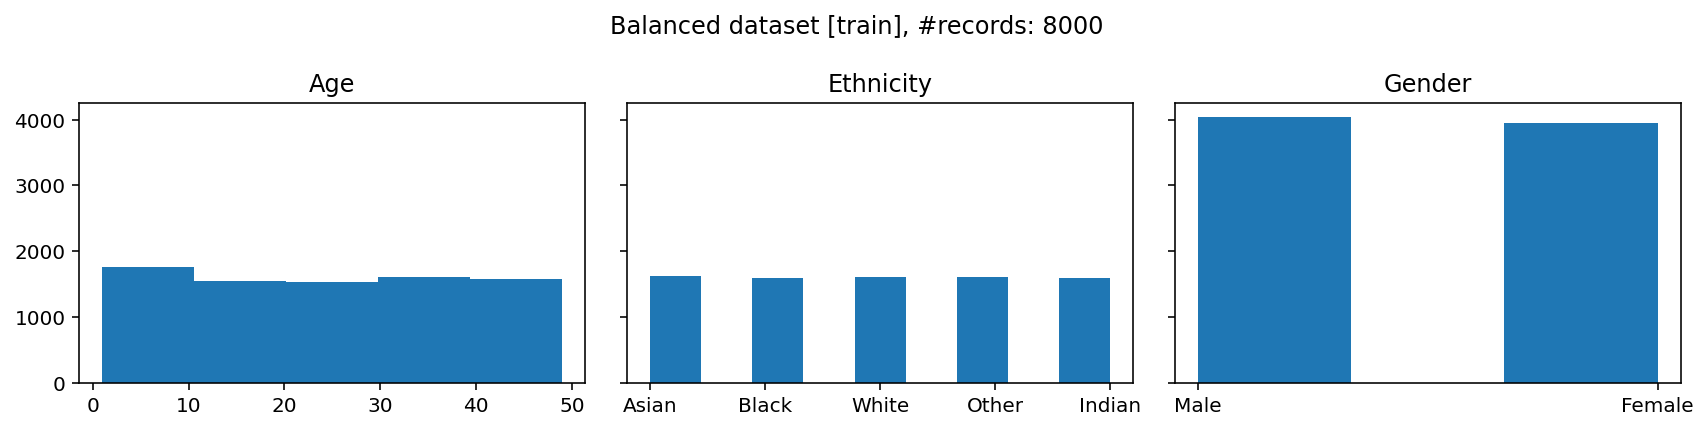

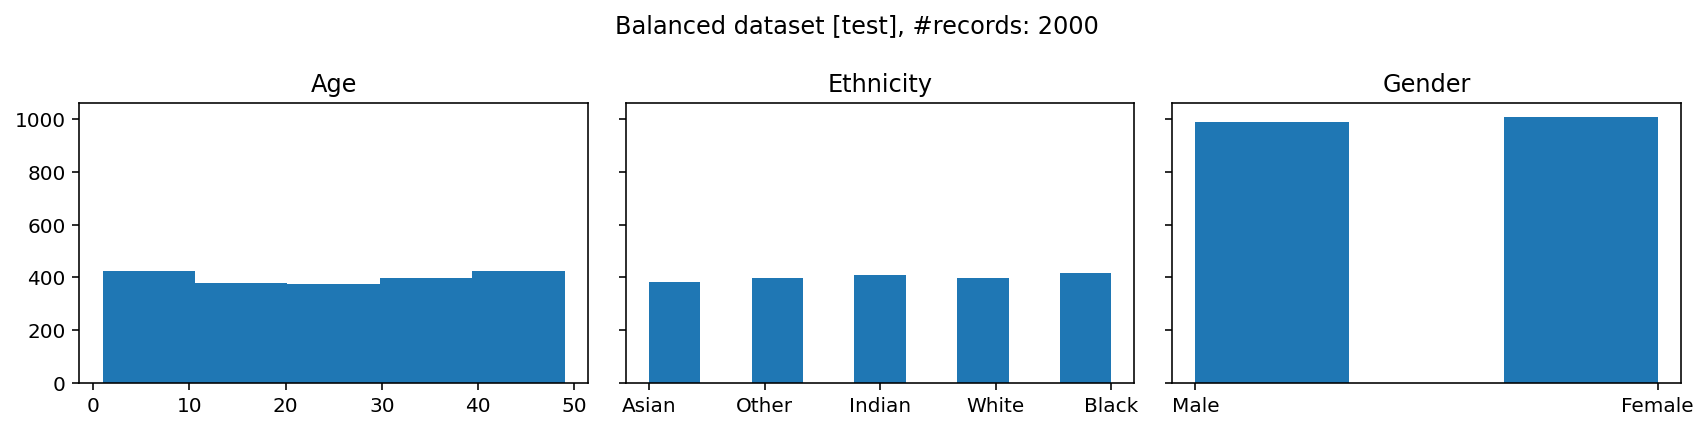

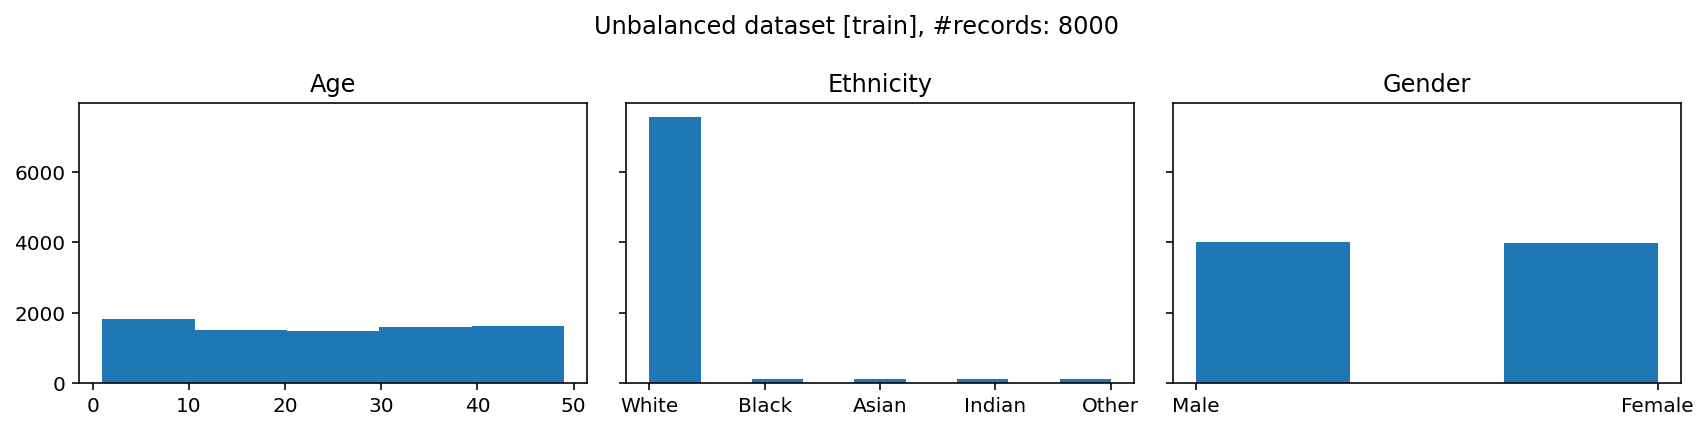

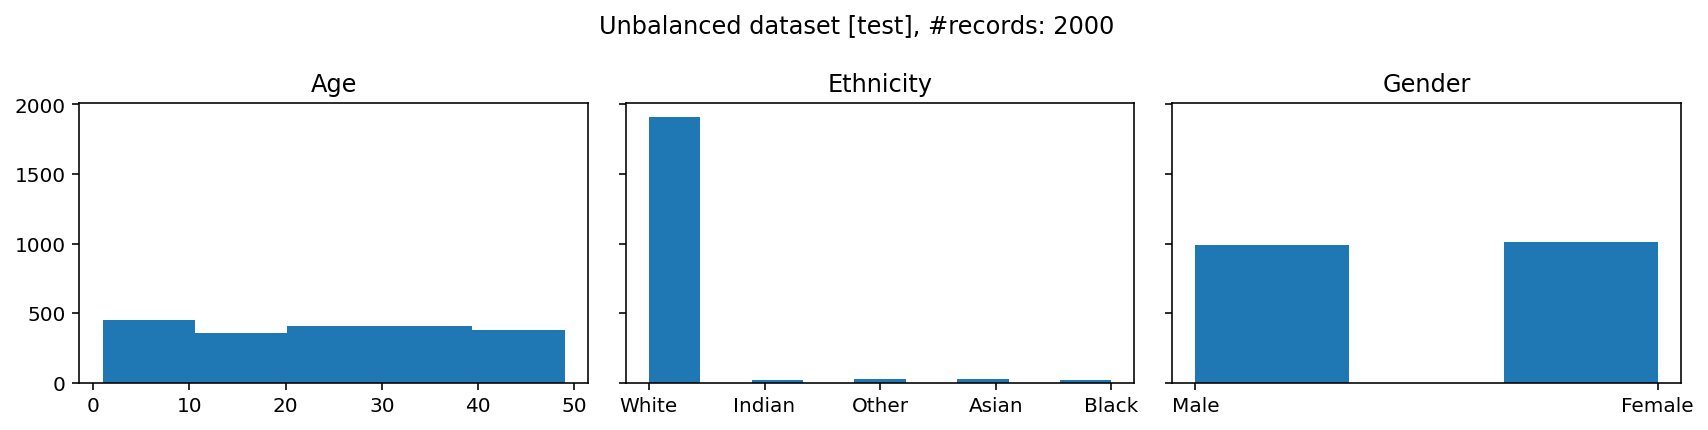

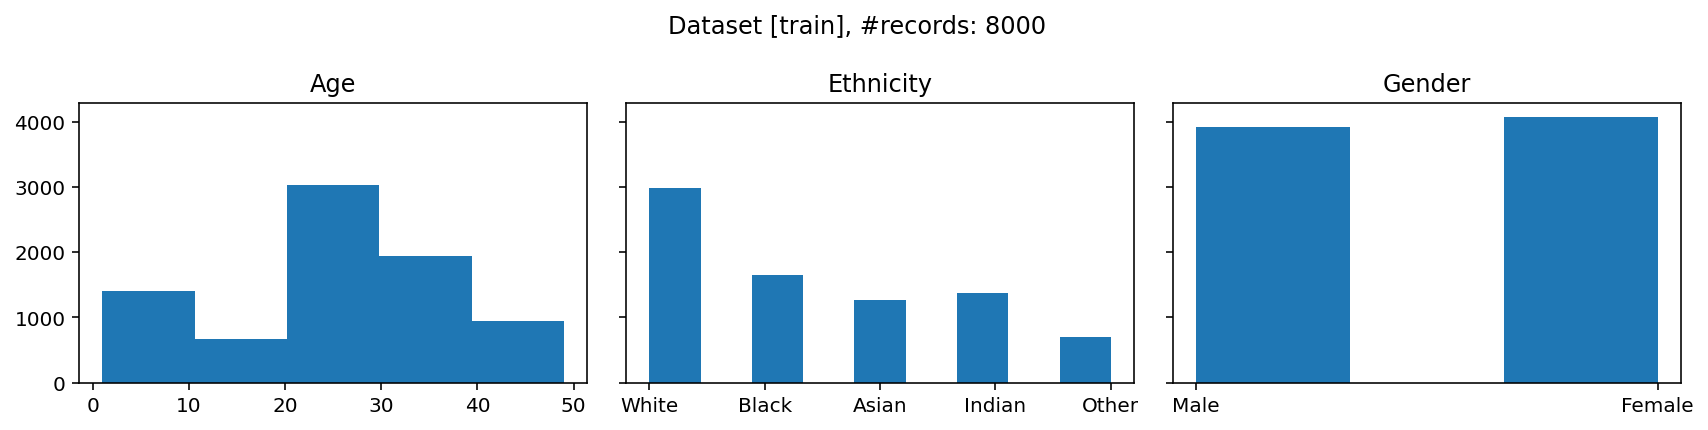

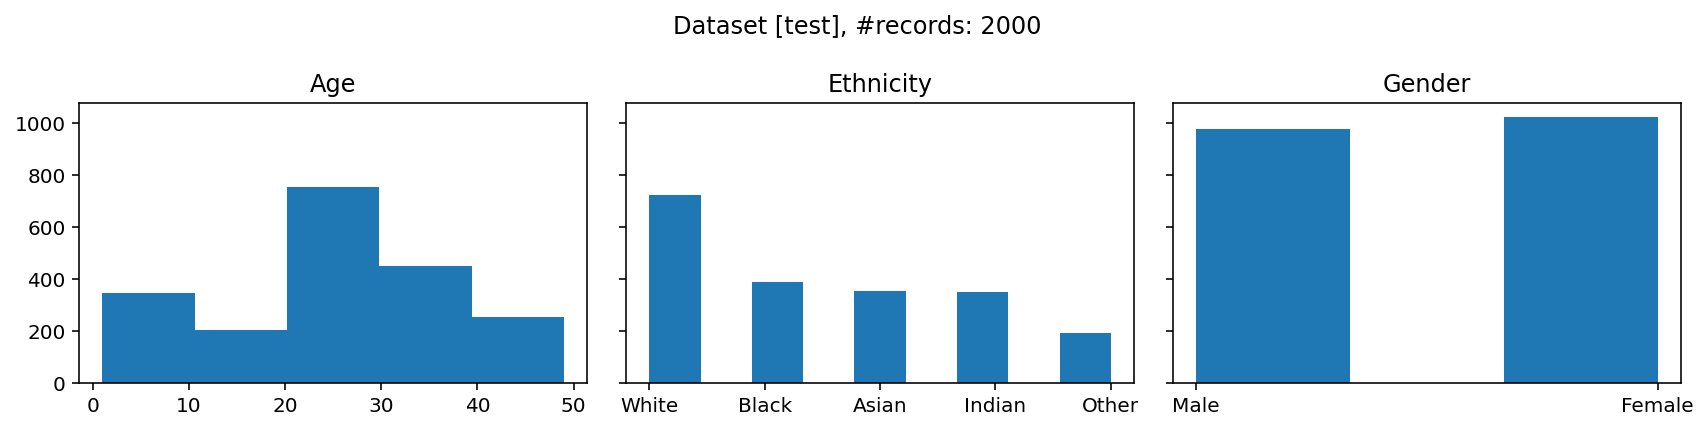

In [21]:
metrics = compare_model_behaviour(
    [balanced_df, unbalanced_df, df.sample(data_samples, random_state=seed)], 
    [standard_nn()] * 3,
    exp_ids=['Balanced dataset', 'Unbalanced dataset', 'Dataset']
)

In [22]:
def get_metrics_data(metrics):
    metrics_df = pd.DataFrame()
    for m in metrics:
        row = pd.Series(m)
        metrics_df = metrics_df.append(row, ignore_index=True)
    return metrics_df

In [23]:
get_metrics_data(metrics)

,experiment ID,data sample #,f1 [macro],White,Black,Asian,Indian,Other
0,Balanced dataset,10000.0,0.132457,0.099006,0.162748,0.089795,0.130407,0.129299
1,Unbalanced dataset,10000.0,0.122726,0.127254,0.063158,0.068966,0.061538,0.139901
2,Dataset,10000.0,0.160104,0.136434,0.146016,0.176253,0.171102,0.160032
